## Book Recommender System

#### Author: Andrew Tran

## Blog Post Inspiration and Objectives

In this blog post, I was hoping to take on the classic beginner/intermediate challenge of creating a simple Machine Learning recommendation system, imitating ones used at Big-Tech companies such as Netflix. Additionally, with so many examples online about Machine Learning movie recommendation systems, I decided to look to establish this system on another area which has always piqued my interest: books. This time I would try to make my own customized RNN if possible, using TensorFlow. With that said, let's try to analyze and create this system with some Machine Learning:

## Data Preprocessing - Cleaning and Analytics

In [1]:
# Import needed libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
color = sns.color_palette()
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score, roc_auc_score, precision_recall_fscore_support, confusion_matrix, classification_report
from sklearn.metrics import mean_squared_error, pairwise_distances
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, dot
from tensorflow.keras.optimizers import Adam
plt.style.use("fivethirtyeight")

First, we will read and display all of the initial datasets in our file system for this blog post, downloaded from Kaggle. These datasets contains loads of valuable information such as Book-ISBNS, user-ids for the (anonymous) users/reviewers, book ratings, etc.

In [2]:
# Reading and displaying all of the initial datasets
books_df = pd.read_csv("datasets/Books.csv")
ratings_df = pd.read_csv("datasets/Ratings.csv")
users_df = pd.read_csv("datasets/Users.csv")

C:\Users\andre\AppData\Local\Temp\ipykernel_21388\2730945584.py:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books_df = pd.read_csv("datasets/Books.csv")


For clarity on the constraints and parameters of the working datasets, I went to find high-level exploratory statistics on all of the datasets: shape, information about all of the entries, etc.

In [3]:
# Determining the shape of each of the initial datasets
books_df.shape, ratings_df.shape, users_df.shape

((271360, 8), (1149780, 3), (278858, 3))

In [4]:
# Figuring out all of the columns (and their names) available for me to use in the dataset
books_df.columns, ratings_df.columns, users_df.columns

(Index(['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher',
        'Image-URL-S', 'Image-URL-M', 'Image-URL-L'],
       dtype='object'),
 Index(['User-ID', 'ISBN', 'Book-Rating'], dtype='object'),
 Index(['User-ID', 'Location', 'Age'], dtype='object'))

In [5]:
# Getting basic information about the all of the datasets
books_df.info(), ratings_df.info(), users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271358 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), obje

(None, None, None)

In [6]:
# Seeing each of the dataframes individually
books_df

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...
...,...,...,...,...,...,...,...,...
271355,0440400988,There's a Bat in Bunk Five,Paula Danziger,1988,Random House Childrens Pub (Mm),http://images.amazon.com/images/P/0440400988.0...,http://images.amazon.com/images/P/0440400988.0...,http://images.amazon.com/images/P/0440400988.0...
271356,0525447644,From One to One Hundred,Teri Sloat,1991,Dutton Books,http://images.amazon.com/images/P/0525447644.0...,http://images.amazon.com/images/P/0525447644.0...,http://images.amazon.com/images/P/0525447644.0...
271357,006008667X,Lily Dale : The True Story of the Town that Ta...,Christine Wicker,2004,HarperSanFrancisco,http://images.amazon.com/images/P/006008667X.0...,http://images.amazon.com/images/P/006008667X.0...,http://images.amazon.com/images/P/006008667X.0...
271358,0192126040,Republic (World's Classics),Plato,1996,Oxford University Press,http://images.amazon.com/images/P/0192126040.0...,http://images.amazon.com/images/P/0192126040.0...,http://images.amazon.com/images/P/0192126040.0...


In [7]:
ratings_df

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6
...,...,...,...
1149775,276704,1563526298,9
1149776,276706,0679447156,0
1149777,276709,0515107662,10
1149778,276721,0590442449,10


In [8]:
users_df

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN
...,...,...,...
278853,278854,"portland, oregon, usa",NaN
278854,278855,"tacoma, washington, united kingdom",50.0
278855,278856,"brampton, ontario, canada",NaN
278856,278857,"knoxville, tennessee, usa",NaN


Before I can pass the datasets over to the Machine Learning model for training and prediction, I had to consolidate all of my datasets into one so that it would be more easier and convenient to analyze. 

In [9]:
# Remove any unnecessary columns (before merging)
books_df.drop(columns=["Image-URL-S", "Image-URL-M", "Image-URL-L"], axis=1, inplace=True)
books_df

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company
...,...,...,...,...,...
271355,0440400988,There's a Bat in Bunk Five,Paula Danziger,1988,Random House Childrens Pub (Mm)
271356,0525447644,From One to One Hundred,Teri Sloat,1991,Dutton Books
271357,006008667X,Lily Dale : The True Story of the Town that Ta...,Christine Wicker,2004,HarperSanFrancisco
271358,0192126040,Republic (World's Classics),Plato,1996,Oxford University Press


In [10]:
# Merge the books and ratings dataframes to have one & inclusive dataframe, 
# combining all book, user, and rating information
df = pd.merge(books_df, ratings_df, on="ISBN")
df

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,User-ID,Book-Rating
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,2,0
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,8,5
2,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,11400,0
3,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,11676,8
4,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,41385,0
...,...,...,...,...,...,...,...
1031131,0440400988,There's a Bat in Bunk Five,Paula Danziger,1988,Random House Childrens Pub (Mm),276463,7
1031132,0525447644,From One to One Hundred,Teri Sloat,1991,Dutton Books,276579,4
1031133,006008667X,Lily Dale : The True Story of the Town that Ta...,Christine Wicker,2004,HarperSanFrancisco,276680,0
1031134,0192126040,Republic (World's Classics),Plato,1996,Oxford University Press,276680,0


Additionally, before handing my combined Book dataset over for Machine Learning training and prediction, I need to clean the data prior to the analysis stage: removing duplicates, deleting null/NaN values, fixing types of columns, filling invalid values with suitable alternatives, etc. Fortunately, the data inherited from Kaggle here is in a preferable format already, so there does not need to be extensive amount of data cleaning here.

In [11]:
# Figuring out the number of duplicated elements in the dataset (could be 
# problematic if not resolved)
df.duplicated().sum()

0

In [12]:
# Figuring out the number of 'null'/'NaN' elements in the dataset (if NaN 
# filling is needed or not)
(df.isnull().sum() / df.shape[0]) * 100

ISBN                   0.000000
Book-Title             0.000000
Book-Author            0.000194
Year-Of-Publication    0.000000
Publisher              0.000194
User-ID                0.000000
Book-Rating            0.000000
dtype: float64

In [13]:
# Fill unknown and unformatted values with proper ones for readability and to
# improve data accuracy and relevance 
df["Book-Author"].fillna("N/A", inplace=True)
df["Publisher"].fillna("N/A", inplace=True)

df["Year-Of-Publication"] = df["Year-Of-Publication"].astype(str)
df["Year-Of-Publication"] = df["Year-Of-Publication"].map(lambda entry: entry if entry.isnumeric() else df["Year-Of-Publication"].mode()[0])
df["Year-Of-Publication"] = df["Year-Of-Publication"].astype("int64")

# Change types of columns to allow an easier time to parse
df["Book-Title"] = df["Book-Title"].astype(str)
df["Book-Author"] = df["Book-Author"].astype(str)
df["ISBN"] = df["ISBN"].astype(str)
df["Publisher"] = df["Publisher"].astype(str)

# Getting basic information about the dataset (once again)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1031136 entries, 0 to 1031135
Data columns (total 7 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   ISBN                 1031136 non-null  object
 1   Book-Title           1031136 non-null  object
 2   Book-Author          1031136 non-null  object
 3   Year-Of-Publication  1031136 non-null  int64 
 4   Publisher            1031136 non-null  object
 5   User-ID              1031136 non-null  int64 
 6   Book-Rating          1031136 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 55.1+ MB


As defined in the code snippet below, with subsequent modifications and copies of the working dataset, there will be a need to quantify the status and real-life/applicable statistics out to you, the user. Thus, I designed a function to report needed information called `report_basic_stats`. From time to time, there will be calls to this function, giving up-to-date information about the state of the dataset currently modified.

In [14]:
def report_basic_stats(dataframe: pd.DataFrame, type: str):
    global n_users, n_books
    n_users = dataframe["User-ID"].unique().shape[0]
    n_books = dataframe["ISBN"].unique().shape[0]
    n_ratings = len(dataframe["Book-Rating"])
    avg_num_ratings_per_user = n_ratings / n_users
    
    print("Number of Unique Book Users in This Dataset ({}):".format(type), n_users)
    print("Number of Unique Book Titles / ISBNs in This Dataset ({}):".format(type), n_books)
    print("Number of Total Ratings in This Dataset ({}):".format(type), n_ratings)
    print("Average Number of Book Ratings per User in This Dataset ({}):".format(type), round(avg_num_ratings_per_user, 3))

Alright, let's begin by looking at the up-to-date information about the state of the original dataset using the `report_basic_stats` function:

In [15]:
report_basic_stats(df, "Regular")

Number of Unique Book Users in This Dataset (Regular): 92106
Number of Unique Book Titles / ISBNs in This Dataset (Regular): 270151
Number of Total Ratings in This Dataset (Regular): 1031136
Average Number of Book Ratings per User in This Dataset (Regular): 11.195


At this point, the data has been cleaned. However, there are some modifications that I have considered in this case such as limiting the amount of Book-ISBNs and Book-Users displayed (up to 3000 in this case). This is intentional to keep the dataset from becoming too long to visualize and compute within the Machine Learning model.

In [16]:
# Filter the first 3000 Book-ISBNs in Dataset
book_isbn_index = df.groupby("ISBN").count().sort_values(by="Book-Rating", ascending=False)[0:3000].index
df2 = df[df["ISBN"].isin(book_isbn_index)]
df2.count()

ISBN                   271456
Book-Title             271456
Book-Author            271456
Year-Of-Publication    271456
Publisher              271456
User-ID                271456
Book-Rating            271456
dtype: int64

In [17]:
# Filter the first 3000 Book-Users in Dataset
book_users_index = df2.groupby("User-ID").count().sort_values(by="Book-Rating", ascending=False)[0:3000].index
df3 = df2[df2["User-ID"].isin(book_users_index)]
df3.count()

ISBN                   172071
Book-Title             172071
Book-Author            172071
Year-Of-Publication    172071
Publisher              172071
User-ID                172071
Book-Rating            172071
dtype: int64

Since I had to cut down to 3000 Book-entries maximum in the dataset, I had to reindex the unique Book-ISBNs and Book User-IDs to account for this filtering. Thus, I removed all entries that were not part of this subset to maintain data consistency and integrity.

In [18]:
# Make a separate dataframe for unique Book-ISBNs
book_isbns = df3["ISBN"].unique()
isbn_df = pd.DataFrame(data=book_isbns, columns=["Original-ISBN"])
isbn_df["New-ISBN"] = isbn_df.index + 1

In [19]:
# Make a separate dataframe for unique Book-Users (indicated by their IDs)
book_users = df3["User-ID"].unique()
users_df = pd.DataFrame(data=book_users, columns=["Original-User-ID"])
users_df["New-User-ID"] = users_df.index + 1

In [20]:
# Merge in new indices for Book-ISBN and Book-User-IDs that are modified
# from 1 to 3000 (accounts for scaling down of data)
cleaned_df = df3.merge(isbn_df, left_on="ISBN", right_on="Original-ISBN")
cleaned_df.drop(columns=["Original-ISBN"], axis=1, inplace=True)

cleaned_df = cleaned_df.merge(users_df, left_on="User-ID", right_on="Original-User-ID")
cleaned_df.drop(columns=["Original-User-ID"], axis=1, inplace=True)
cleaned_df

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,User-ID,Book-Rating,New-ISBN,New-User-ID
0,0440234743,The Testament,John Grisham,1999,Dell,277478,0,1,1
1,0971880107,Wild Animus,Rich Shapero,2004,Too Far,277478,0,3,1
2,0671888587,I'll Be Seeing You,Mary Higgins Clark,1994,Pocket,277478,0,9,1
3,0440225701,The Street Lawyer,JOHN GRISHAM,1999,Dell,277478,0,15,1
4,0786868716,The Five People You Meet in Heaven,Mitch Albom,2003,Hyperion,277478,0,30,1
...,...,...,...,...,...,...,...,...,...
172066,0767908171,A Short History of Nearly Everything,Bill Bryson,2003,Broadway,70999,0,2798,3000
172067,0385234104,Fatherhood,Bill Cosby,1986,Bantam Dell Pub Group,70999,0,2857,3000
172068,0425190641,Fire Ice: A Novel from the Numa Files (Kurt Au...,Clive Cussler,2003,Berkley Publishing Group,70999,0,2874,3000
172069,0553584375,No One to Trust,IRIS JOHANSEN,2003,Bantam,70999,0,2880,3000


Here, I am trying to offer some visualizations of the cleaned dataset before we pass it over for Machine Learning training and prediction. The first visualization (below) describes about the total number of reviews given to each of the 3000 books in the dataset. Arbitrarily though, I set a maximum of 30 book titles visualized to save space as my editor could not plot more than that without it become illegible. The strategy there was grouping by Book-Titles and and counting number of Book-Rating entries for that particular Book entry.

In [21]:
# Make a copy of the cleaned dataframe
cleaned_df_condensed_trends = cleaned_df.copy()

# Drop unnecessary columns
cleaned_df_condensed_trends.drop(labels=["ISBN", 
                                         "Book-Author",
                                         "Year-Of-Publication",
                                         "Publisher",
                                         "User-ID",
                                         "New-ISBN",
                                         "New-User-ID"], axis=1, inplace=True)

# Used grouping and counting to gather book-review counts for each indexed title
cleaned_df_condensed_trends_copy = cleaned_df_condensed_trends.copy()
cleaned_df_condensed_trends = pd.DataFrame(cleaned_df_condensed_trends_copy
                                           .groupby("Book-Title")["Book-Rating"]
                                           .mean())
cleaned_df_condensed_trends["Total-Num-Of-Ratings"] = pd.DataFrame(cleaned_df_condensed_trends_copy
                                                                   .groupby("Book-Title")["Book-Rating"]
                                                                   .count())
cleaned_df_condensed_trends.head(10)

,Book-Rating,Total-Num-Of-Ratings
Book-Title,,
10 Lb. Penalty,1.911765,34
16 Lighthouse Road,1.276596,47
1984,3.817460,126
1st to Die: A Novel,2.893891,311
2010: Odyssey Two,2.086207,58
204 Rosewood Lane,1.581818,55
2061: Odyssey Three,3.133333,30
24 Hours,1.454545,44
2nd Chance,2.704167,240


C:\Users\andre\AppData\Local\Temp\ipykernel_21388\177655821.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(cleaned_df_condensed_trends.index,


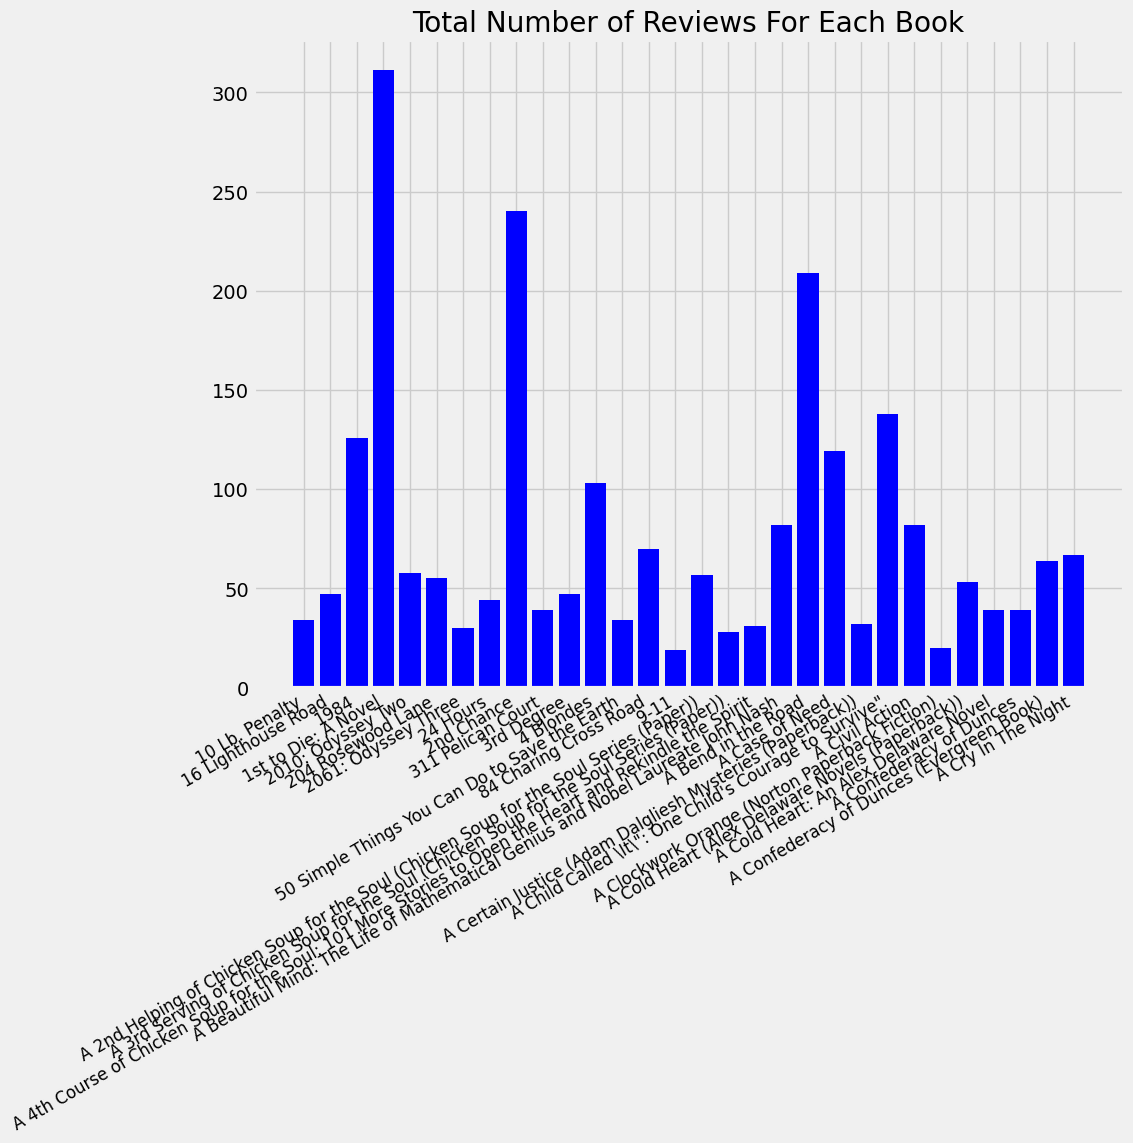

In [22]:
# Creating a bar graph describing number of reviews for first 30 books
plt.figure(figsize=(10, 8))
ax=plt.subplot()
ax.bar(cleaned_df_condensed_trends.head(30).index,
       cleaned_df_condensed_trends["Total-Num-Of-Ratings"].head(30), 
       color="b")
ax.set_xticklabels(cleaned_df_condensed_trends.index,
                   rotation=30,
                   fontsize="12",
                   horizontalalignment="right")
ax.set_title("Total Number of Reviews For Each Book")
plt.show()

Just to give an interesting statistic, I decided to make another copy of the working dataset, grouped by Book-Title but sorted by Book-Rating. This was intentional to output and report the most-popular (Top-50 rated books) and least-populat (Bottom-50 rated books) on average, which is an important piece of data for the user to know.

In [23]:
# Calculate mean rating of all books (copy of cleaned dataframe)
# Output the Top-50 and Bottom-50 rated books on average
cleaned_df_sorted_mean_rating = cleaned_df.copy().groupby("Book-Title")["Book-Rating"].mean().sort_values(ascending=False)
print("--------- Sorted by Mean On Average: ---------\n")
print("--------- TOP 50: ---------\n", cleaned_df_sorted_mean_rating.head(50))
print("\n\n--------- BOTTOM 50: ---------\n", cleaned_df_sorted_mean_rating.tail(50))

--------- Sorted by Mean On Average: ---------

--------- TOP 50: ---------
 Book-Title
Generation Golf. Eine Inspektion                                                                          9.000000
Novocento, Un Monologo                                                                                    9.000000
Io Non Ho Paura                                                                                           8.000000
Herr Lehmann.                                                                                             7.500000
L'Etranger (Collection Folio, 2)                                                                          6.777778
Griffin &amp; Sabine: An Extraordinary Correspondence                                                     6.000000
The Darwin Awards: Evolution in Action                                                                    5.653846
Harry Potter and the Sorcerer's Stone (Book 1)                                                            5

The second visualization gathers all of the numerical book-ratings across all books, contrasting how book reviewers score and evaluate these literature text sources generally. With this ranged data, it would seem most appropriate to display this visualization of statistical data within a histogram.  

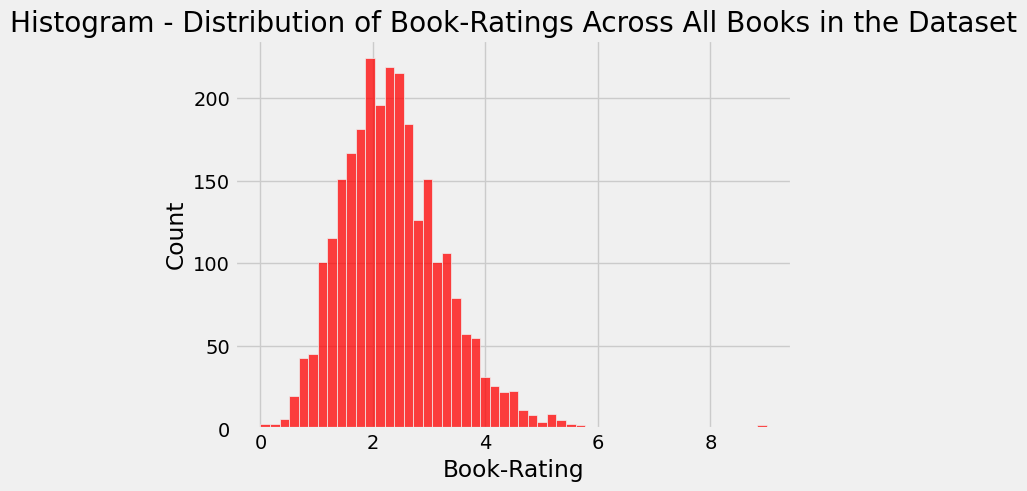

In [24]:
sns.histplot(pd.DataFrame(cleaned_df_sorted_mean_rating)["Book-Rating"], color="r")
plt.title("Histogram - Distribution of Book-Ratings Across All Books in the Dataset")
plt.show()

As compared to earlier, let's look at the up-to-date information about the state of the reduced (in-size) dataset using the `report_basic_stats` function.

In [25]:
report_basic_stats(cleaned_df, "Reduced")

Number of Unique Book Users in This Dataset (Reduced): 3000
Number of Unique Book Titles / ISBNs in This Dataset (Reduced): 3000
Number of Total Ratings in This Dataset (Reduced): 172071
Average Number of Book Ratings per User in This Dataset (Reduced): 57.357


## Machine Learning - Model Training and Evaluation

Great, now we are onto the Machine Learning part of the blog post!

Since the dataframe is now properly cleaned by this point, I had split the respective dataframe into the train, test, and validation datasets for the Machine Learning model with 90% going to the training dataset, the next 5% going to the validation dataset, and the last 5% going to the test dataset. Fortunately, because order of the data sequentially does not matter here, I was able to utilize the `train_test_split` function for shuffling and randomization, making the future-generated Machine Learning model more unpredictable but also more objective in its returned model results.

In [26]:
# Configuring the Machine Learning Tensorflow Model by splitting the data 90% for testing,
# 5% for validation, and 5% for testing
X_train, X_test = train_test_split(cleaned_df, test_size=0.10, shuffle=True, random_state=2018)
X_val, X_test = train_test_split(X_test, test_size=0.50, shuffle=True, random_state=2018)

In [27]:
# Outputting the shape of the new datasets
print("Shape of Training Set:", X_train.shape, "and Size of Training Set:", X_train.size)
print("Shape of Validation Set:", X_val.shape, "and Size of Validation Set:", X_val.size)
print("Shape of Test Set:", X_test.shape, "and Size of Testing Set:", X_test.size)

Shape of Training Set: (154863, 9) and Size of Training Set: 1393767
Shape of Validation Set: (8604, 9) and Size of Validation Set: 77436
Shape of Test Set: (8604, 9) and Size of Testing Set: 77436


As recommended online for any Collaborative-Filtering Recommendation Systems, one suggestion was to manually check and compute the `mean_squared_error` for ratings in your dataset. Thus, I defined a cost function that utilizes a sparse `np.array` starting with all 0's of dimension-size `n_users x n_books`.  The entries at specified locations would be converted non-zero by utilizing every Book-ISBN and Book User-ID position to generate a computed rating. The objective with calculating the `mean_squared_error` is to check how close estimates are to actual, observed values found within the given dataset.

In [28]:
# Define my cost function (mean-squared error) for each dataset before the
# invokation of the Machine Learning algorithm
df_ratings_train = np.zeros((n_users, n_books))
for r in X_train.itertuples():
    df_ratings_train[r[9] - 1, r[8] - 1] = r[7]
print(df_ratings_train.shape)
df_ratings_train

(3000, 3000)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [29]:
df_ratings_validation = np.zeros((n_users, n_books))
for r in X_val.itertuples():
    df_ratings_validation[r[9] - 1, r[8] - 1] = r[7]
print(df_ratings_validation.shape)
df_ratings_validation

(3000, 3000)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [30]:
df_ratings_test = np.zeros((n_users, n_books))
for r in X_test.itertuples():
    df_ratings_test[r[9] - 1, r[8] - 1] = r[7]
print(df_ratings_test.shape)
df_ratings_test

(3000, 3000)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

After the dataframes had the cost function computed for all, I made 2 matrices - one for the book user-similiarity and one for the book item-similarity. The idea here is to account for relative difference in the ratings between several distinct Book-Users and Book-ISBNs (items) themselves. Statically proven, relative differences in ratings give more insight than the absolute rating values. As described on the CambridgeSpark reference below, the rating system could be skewed by human biases such as solid consistent ratings for good vs. bad books through cover inspection, ratings based on topic preference or thoughts on the user's views rather than objective review, etc. 

Note that in the user-based similarity predictions that ratings as weights need to be normalized, so summation and average on top of a dot-product calcuation on the matrix is needed. This is to make sure the ratings stay within the expected range of 1.0 (worst) to 10.0 (best).

At the end of the code cell below, a comparison on the prediction matrices with the `df_ratings_test` matrix using dimensionality reduction and the `mean_squared_error` function the `sklearn.metrics` module is computed to quantify the closeness of estimates to the actual dataset (as described previously).

In [31]:
# Computes the cosine similarity between all books using pairwise distancing
book_user_similarity = pairwise_distances(df_ratings_train, metric="cosine")
book_item_similarity = pairwise_distances(df_ratings_train.T, metric="cosine")

# Calculates prediction ratio for book_users and book_items
def perform_prediction_similarity_based(ratings, similiarity, pred_type="user"):
    if pred_type == "user":
        mean_user_rating = ratings.mean(axis=1)
        # You use np.newaxis so that the user_rating has the same format as ratings
        ratings_diff = (ratings - mean_user_rating[: np.newaxis])
        pred = mean_user_rating[: np.newaxis] + (similiarity.dot(ratings_diff) / np.array([np.abs(similiarity).sum(axis=1)]))
    elif pred_type == "item":
        pred = ratings.dot(similiarity) / np.array([np.abs(similiarity).sum(axis=1)])
    return pred

book_user_prediction = perform_prediction_similarity_based(df_ratings_train, book_user_similarity, pred_type="user")
book_item_prediction = perform_prediction_similarity_based(df_ratings_train, book_item_similarity, pred_type="item")

# Using predictions, calculates the mean squared error for each book_user and
# book_item
def compute_mean_square_error(predicted, actual):
    predicted = predicted[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(predicted, actual)

print("For Collaborative Filtering:")
print(f"Book User-Based Mean-Square-Error: {compute_mean_square_error(book_user_prediction, df_ratings_test)}")
print(f"Book Item-Based Mean-Square-Error: {compute_mean_square_error(book_item_prediction, df_ratings_test)}")

For Collaborative Filtering:
Book User-Based Mean-Square-Error: 63.272539998623145
Book Item-Based Mean-Square-Error: 62.53832448961992


One other calculation that is beneficial to check with regards to these matrices includes matrix sparsity. With a less sparse matrix (through a lower-percentage return), I found that it was more beneficial to more efficient to use dense Machine Learning representations and algorithms optimized for dense data, which will done later while creating the Sequential layering of the model. After performing the calculations below, this seemed to be the case I was dealing with here.

In [32]:
# Outputs the sparsity stats of a given dataframe
def print_sparsity_stats(df: pd.DataFrame, type: str):
    print("-------------- Sparsity Stats for {}: --------------".format(type))
    df_sparsity = float(len(df.nonzero()[0]))
    df_sparsity /= (df.shape[0] * df.shape[1])
    df_sparsity *= 100
    print('Sparsity: {:4.2f}%'.format(df_sparsity))

In [33]:
# Check the sparsity stats of the ratings' train, validation, and test np.arrays
print_sparsity_stats(df_ratings_train, "Train")
print_sparsity_stats(df_ratings_validation, "Validation")
print_sparsity_stats(df_ratings_test, "Test")

-------------- Sparsity Stats for Train: --------------
Sparsity: 0.53%
-------------- Sparsity Stats for Validation: --------------
Sparsity: 0.03%
-------------- Sparsity Stats for Test: --------------
Sparsity: 0.03%


Now, I began to configure the Machine Learning model. We added Sequential layers of Input: incorporated an Input layer 1 by 1 because I only had 1 `np.array` as Input for Book-Users and another one as Input for Book-Items themselves, utilize a Embedding as recommended for each of the Input layers for models like these, and I followed up with flattening for dimensionality-reduction of both embeddings with input. Combining it with the dot-product of the two vector embeddings with input to make the initial model, we compiled it, utilzing the `mean_square_error` as our minimizing loss function, using the `Adam` optimizer, and comparing our trained model against our data with the `mean_absolute_error` metric. Lastly, I fitted our model, utilzing both of our X_train datasets and the Y_train dataset for fitting with validation from both of our X_val datasets and the Y_val dataset at 100 epochs.

In [34]:
# Apply the Input, Embeddings, and Dot Product on the Model
n_latent_fact = 1
user_input = Input(shape=[1], name="User")
user_embedding = Embedding(input_dim=n_users + 1, 
                           output_dim=n_latent_fact, 
                           name="User_Embedding")(user_input)
user_vec = Flatten(name="Flatten_Users")(user_embedding)
book_input = Input(shape=[1], name="Book")
book_embedding = Embedding(input_dim=n_books + 1, 
                           output_dim=n_latent_fact, 
                           name="Book_Embedding")(book_input)
book_vec = Flatten(name="Flatten_Movies")(book_embedding)
dot_product = dot([book_vec, user_vec], axes=1)
model = Model(inputs=[user_input, book_input], outputs=dot_product)

# Compile the model and fit the datasets to it
model.compile(loss="mse",
              optimizer=Adam(learning_rate=0.001),
              metrics=["mean_absolute_error"])

book_rec_history = model.fit(x=(X_train["New-User-ID"], X_train["New-ISBN"]), 
                             y=X_train["Book-Rating"],
                             epochs=100,
                             validation_data=([X_val["New-User-ID"], X_val["New-ISBN"]], X_val["Book-Rating"]),
                             use_multiprocessing=True)

Epoch 1/100
4840/4840 [==============================] - 19s 4ms/step - loss: 19.9797 - mean_absolute_error: 2.4201 - val_loss: 19.7893 - val_mean_absolute_error: 2.3978
Epoch 2/100
4840/4840 [==============================] - 18s 4ms/step - loss: 19.8125 - mean_absolute_error: 2.4261 - val_loss: 19.3482 - val_mean_absolute_error: 2.4141
Epoch 3/100
4840/4840 [==============================] - 17s 4ms/step - loss: 18.9626 - mean_absolute_error: 2.4541 - val_loss: 18.2233 - val_mean_absolute_error: 2.4600
Epoch 4/100
4840/4840 [==============================] - 17s 4ms/step - loss: 17.6552 - mean_absolute_error: 2.4998 - val_loss: 16.9332 - val_mean_absolute_error: 2.5152
Epoch 5/100
4840/4840 [==============================] - 21s 4ms/step - loss: 16.3179 - mean_absolute_error: 2.5432 - val_loss: 15.7842 - val_mean_absolute_error: 2.5636
Epoch 6/100
4840/4840 [==============================] - 20s 4ms/step - loss: 15.1464 - mean_absolute_error: 2.5718 - val_loss: 14.8412 - val_mean_abs

To measure the change in the `mean_absolute_error` statistic within my epochs (or run through the datasets) during the attempt to fit the Machine Learning model above as they were being completed, I made a line-graph visualization to see the fluctuation in the error as shown below. 

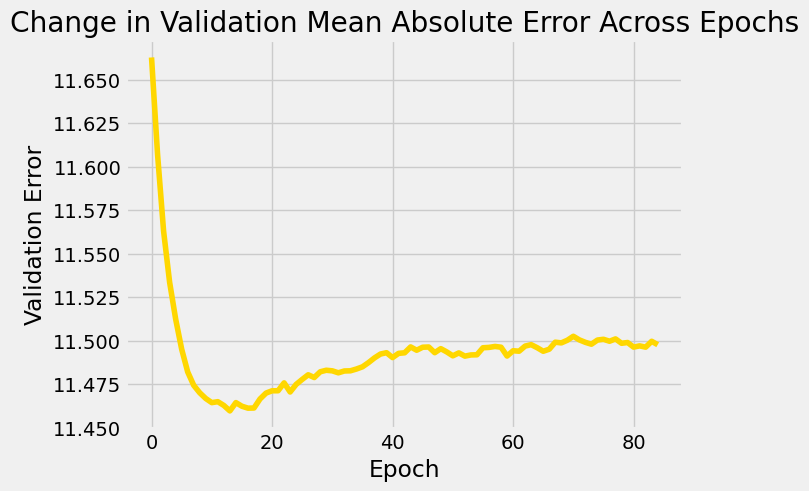

Minimum MSE: 11.459701538085938


In [35]:
# Plot the Validation Mean Absolute Error throughout the fitting of the model across epochs
pd.Series(book_rec_history.history["val_loss"][15:]).plot(logy=False, color="gold")
plt.xlabel("Epoch")
plt.ylabel("Validation Error")
plt.title("Change in Validation Mean Absolute Error Across Epochs")
plt.show()

print("Minimum MSE:", min(book_rec_history.history["val_loss"]))

With the Machine Learning model fitted, it would be a good time to evaluate the effectiveness of my model. Thus, I will calculate metrics (as shown below) such as `Precision Score`, `ROC-AUC (Receiver Operating Characteristic (Curve) - Area Under the Curve) Score`, `F1 Score`, `Recall Score`, and the `Confusion Matrix`. For the classification metrics, I applied a threshold rating of 5.0 or above to indicate as an acceptable rating to recommend a book, based on the logic that there would be more positive than negative reviews for that book-title, on average. All of the calcuations are shown in the following code snippet as well as its corresponding visualizations.

269/269 [==============================] - 0s 1ms/step - loss: 11.4746 - mean_absolute_error: 2.5767
Average Precision Score (When Compared to Test Set): 39.63%
_______________________________________________
Accuracy Score (When Compared to Test Set): 25.77%)
_______________________________________________
ROC AUC Score: 72.26%
_______________________________________________
CLASSIFICATION REPORT:
                     0           1  accuracy    macro avg  weighted avg
precision     0.952507    0.254724  0.746513     0.603616      0.876678
recall        0.753162    0.691979  0.746513     0.722570      0.746513
f1-score      0.841185    0.372374  0.746513     0.606780      0.790240
support    7669.000000  935.000000  0.746513  8604.000000   8604.000000
_______________________________________________
Precision Score: 69.20%
_______________________________________________
Recall Score: 25.47%
_______________________________________________
F1 Score: 37.24%
________________________________

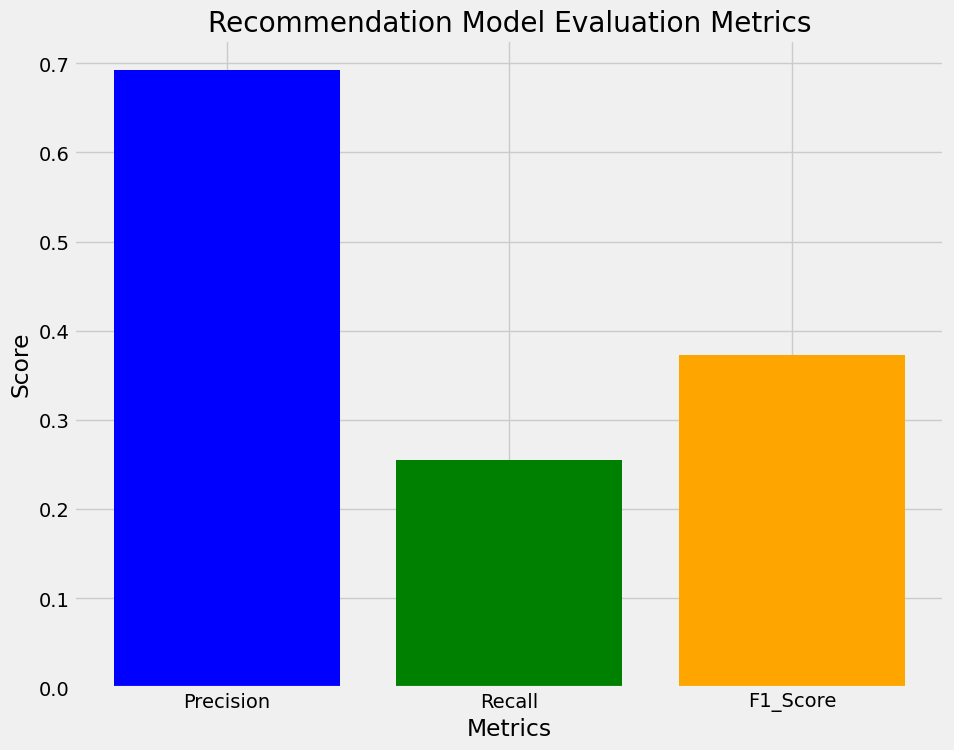

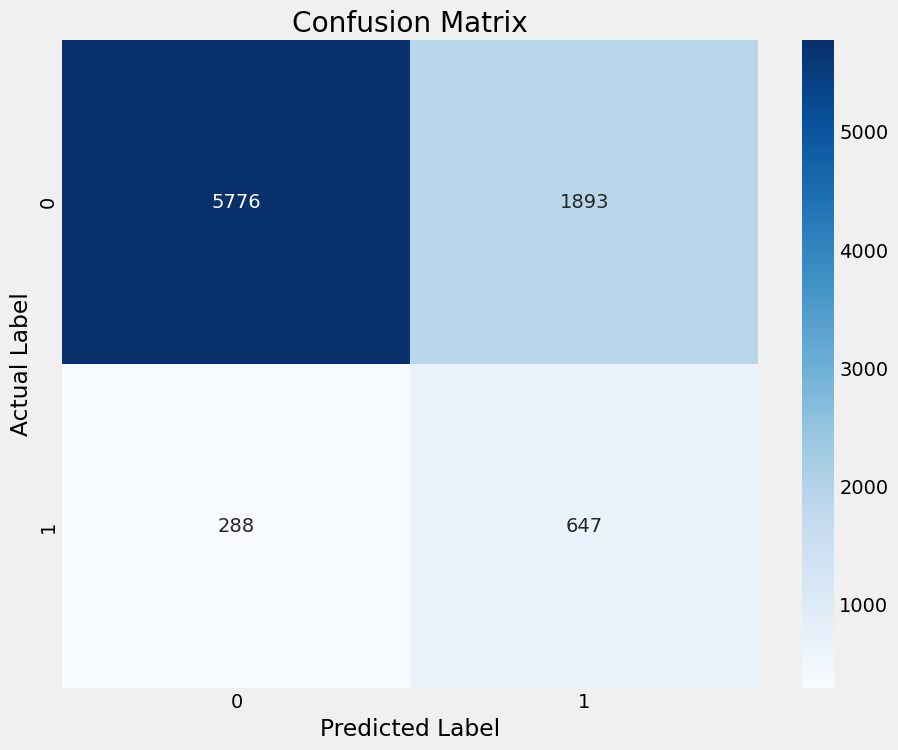

In [36]:
predicted_ratings = model.predict(x=(X_test["New-User-ID"], X_test["New-ISBN"])).flatten()

book_rec_history_model_loss, book_rec_history_model_accuracy = model.evaluate(x=(X_test["New-User-ID"], X_test["New-ISBN"]), y=X_test["Book-Rating"])
book_rec_history_model_accuracy /= 10

# Threshold the predicted ratings to binary-classified recommendations (e.g., using a threshold of >= 5 for recommending book)
threshold = 5
predicted_labels_bin_classify = (predicted_ratings.copy() >= threshold).astype(int)
actual_labels_bin_classify = (X_test["Book-Rating"].copy() >= threshold).astype(int)

actual_ratings_int = predicted_labels_bin_classify.copy().astype(int)
predicted_ratings_int = actual_labels_bin_classify.copy().astype(int)
clf_report = pd.DataFrame(classification_report(y_true=actual_ratings_int, y_pred=predicted_ratings_int, output_dict=True, zero_division=0))

y_test_book_rating = predicted_labels_bin_classify
y_pred_book_rating = actual_labels_bin_classify

avg_precision_score = average_precision_score(y_true=actual_labels_bin_classify, y_score=predicted_labels_bin_classify)

# Compute and output statistics for Average Precision, Accuracy, and ROC AUC Scores as well as the Classifcation Report
print(f"Average Precision Score (When Compared to Test Set): {avg_precision_score * 100:.2f}%")
print("_______________________________________________")
print(f"Accuracy Score (When Compared to Test Set): {book_rec_history_model_accuracy * 100:.2f}%)")
print("_______________________________________________")
print(f"ROC AUC Score: {roc_auc_score(y_test_book_rating, y_pred_book_rating) * 100:.2f}%")
print("_______________________________________________")
print(f"CLASSIFICATION REPORT:\n{clf_report}")

# Calculate and output Precision, Recall, F1-Score, and Confusion Matrix
precision, recall, f1_score, _ = precision_recall_fscore_support(y_true=actual_labels_bin_classify, y_pred=predicted_labels_bin_classify, average='binary')
model_performance_metrics: [str] = ["Precision", "Recall", "F1_Score"]
model_performance_metrics_values: [float] = [precision, recall, f1_score]
print("_______________________________________________")
print(f"Precision Score: {precision * 100:.2f}%")
print("_______________________________________________")
print(f"Recall Score: {recall * 100:.2f}%")
print("_______________________________________________")
print(f"F1 Score: {f1_score * 100:.2f}%")
print("_______________________________________________")
print(f"Confusion Matrix:\n{confusion_matrix(y_test_book_rating, y_pred_book_rating)}")

plt.figure(figsize=(10, 8))
plt.bar(model_performance_metrics, model_performance_metrics_values, color=["blue", "green", "orange"])
plt.xlabel("Metrics")
plt.ylabel("Score")
plt.title("Recommendation Model Evaluation Metrics")
plt.show()

# Create the confusion matrix
conf_matrix = confusion_matrix(y_test_book_rating, y_pred_book_rating)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix')
plt.show()

## Conclusions

- Based on the `Accuracy Score` at `25.75%`, `Precision Score` at `68.86%`, and Recall Score at `25.51%`, I found that my simple Book Recommendation Machine Learning model was not as good as I hoped in utilzing the train and validation datasets to fit my model in order to evaluate with my testing dataset. Looking at back my steps / approach, I realize that I may have overfitted by a great amount by training my Machine Learning model above approximately 10-15 epochs. When looking closely at the `Change in Validation Mean Absolute Error Across Epochs` Visualization, the validation error (i.e. the validation loss) was at its lowest in this duration and only went up from there in subsequent epoch training iterations. I would most likely re-train the model if I did this blog post project again.

- Utimately, I learned a great deal from this blog post as I now better understand how basic Input/Embeddings/Output from `Tensorflow` works in the topic of neural networks in Machine Learning. Of course, seeing the real life implications of recommendation systems like this (but scaled up on a much higher, economic level) makes me appreciate the complexity of this disclipine and ML-subfield because reaching the end of this blog post was nonetheless difficult for my basic implementation. I cannot imagine what it must be like to have to maintain larger, production-critical systems that tackle these problems on a daily basis.

## Reference Sources and Citations (IEEE Format)

To complete this blog post, I used the following online sources as references for developing this:

[1] Book Recommendation Dataset:

- Möbius, "Book Recommendation Dataset", Apr.-2023. [Online]. Available: https://www.kaggle.com/datasets/arashnic/book-recommendation-dataset. [Accessed: 25-Sep.-2023].

[2] Tutorial on Basics of Machine Learning Recommendation Systems:

- M. Ahammad, "Movie Recommender Systems Using Neural Network," 2020. [Online]. Available: https://www.kaggle.com/code/mejbahahammad/movie-recommender-systems-using-neural-network. [Accessed: 25-Sep.-2023].

[3] Tutorial on Sample Visualizations for Machine Learning Recommendation Systems:

- Great Learning Team, "Excerpts From a Masterclass on Movie Recommendation System," 22-Aug.-2022. Available: https://www.mygreatlearning.com/blog/masterclass-on-movie-recommendation-system/. [Accessed: 26-Sep.2023].

[4] Tutorial on Evaluating Machine Learning Recommendation Systems:

- A. Johannsdottir, "Implementing Your Own Recommmender Systems in Python", 28-Nov.-2019. Available: https://www.cambridgespark.com/info/recommender-systems-in-python. [Accessed: 27-Sep.2023].